In [7]:
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [8]:
opinions = pd.read_csv('csv_data/preprocesed_files/anomaly_opinions.csv')
# Tworzenie listy krotek
opinions_list = [(row['content'], row['doubleQuality']) for _, row in opinions.iterrows()]
random.shuffle(opinions_list)


In [9]:
# opinions_list=opinions_list[0:3000]
sum_of_values = sum(item[1] for item in opinions_list)
print(sum_of_values)  #

107


In [10]:
nlp = spacy.load('pl_core_news_md')

# Obiekt PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

# Lista fraz
term_list = ["lepszy niż", "lepszy od", "nie ma już", "na rynku", "w polskich", "lepszej jakosci", "od niemca", "nad polskimi",
             "tak dobrze jak", "jak niemiecki", "polskiej wersji", "nad polskimi", "jak niemiecki", "najlepszy bo", "polski produkt",
             "niemieckie wydanie", "jest Niemieckim", "oryginalne niemieckie", "z niemiec", "to niemiecki", "niemiecka chemia",
             "niemiecka jakość", "oryginalny produkt", "rynek zachodni", "lepsza niż", "rynek polski", "zachodni rynek",
             "niemiecki rynek", "jak polski", "wyprodukowany w", "produkowany w niemczech", "nie dorównują", "polskiej wersji", "europę wschodnią"]
print(len(term_list))
term_list = list(set(term_list))
print(len(term_list))


34
31


In [11]:

def rule_based_double_quality_search(dataset, term_list):

    total_sentences = len(dataset)
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    # Konwersja fraz na obiekty typu Document
    patterns = [nlp.make_doc(t) for t in term_list]

    # Dodanie wzorców do obiektu matcher
    matcher.add("Phrase Match", None, *patterns)

    for txt in dataset:
        # Tekst wejściowy jako obiekt typu Document
        doc = nlp(txt[0])
        
        # Wywołanie metody matcher na obiekcie doc. Zwraca obiekty typu Span
        matches = matcher(doc, as_spans=True)
        
        if len(matches) > 0:
            if(txt[1] == 1):
                true_positives += 1
            else:
                false_positives += 1
        else:            
            if(txt[1] == 0):
                true_negatives += 1
            else:
                false_negatives += 1
    
    print("Liczba zdań ze zbioru: ", total_sentences)
    print("TP: ", true_positives)
    print("FN: ", false_negatives)
    print("FP: ", false_positives)
    print("TN: ", true_negatives)
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    loss = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
      
    print("Miary:")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Accuracy: ", accuracy)
    print("Loss: ", loss)
    print("F1: ", f1_score)


    confusion_matrix = [[true_positives, false_negatives], [false_positives, true_negatives]]

    # Wykreślenie Confusion Matrix
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()



Liczba zdań ze zbioru:  107
TP:  52
FN:  55
FP:  0
TN:  0
Miary:
Precision:  1.0
Recall:  0.48598130841121495
Accuracy:  0.48598130841121495
Loss:  0.514018691588785
F1:  0.6540880503144654


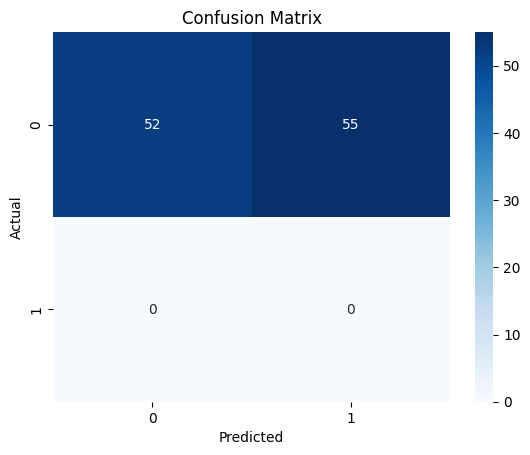

In [12]:
# Oblicz miary dla zbioru anomaly_opinions
rule_based_double_quality_search(opinions_list, term_list)